# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

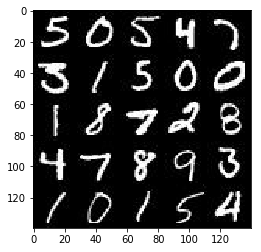

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot


mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

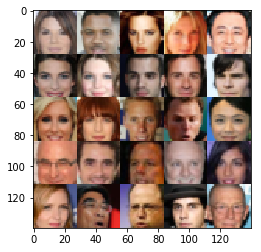

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    
    learn_rate = tf.placeholder(tf.float32, [], name='learning_rate')
    real_inputs = tf.placeholder(tf.float32, (None,image_width, image_height, image_channels), name = 'real_inputs')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name = 'inputs_z')


    return real_inputs,inputs_z, learn_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.2
    
    with tf.variable_scope('discriminator', reuse=reuse):
        #Input layer is 28x28x3
        
        #16x16x64 Xavier initializer 
        x1 = tf.layers.conv2d(images, 64, 5, strides = 2, padding = 'same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        relu1 = tf.maximum(alpha*x1,x1)

        #8x8x128   
        x2 = tf.layers.conv2d(relu1, 128, 5, strides = 2, padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha*bn2,bn2)
        relu2 = tf.nn.dropout(relu2, keep_prob=0.9)
        
        #4x4x256   
        x3 = tf.layers.conv2d(relu2, 256, 5, strides = 2, padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha*bn3,bn3)
        relu3 = tf.nn.dropout(relu3, keep_prob=0.9)
    
        #Flatten it
        flat = tf.contrib.layers.flatten(relu3)
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    
        
        return out, logits
        
       


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    # 7x7x256 > 14x14x128 > 28x28x3 
    
    training = is_train
    alpha=0.2
    
    with tf.variable_scope('generator', reuse= not is_train):
        #First fully connected layer
        x1 = tf.layers.dense(z, 7*7*1024)
        
        #reshape it to start the convolutional stack 
        x1 = tf.reshape(x1, (-1, 7, 7, 1024))
        x1 = tf.maximum(alpha * x1, x1)

        # 7x7x1024 now 
        
        x2 = tf.layers.conv2d_transpose(x1, 512, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=training)
        x2 = tf.maximum(alpha *x2, x2)
        x2 = tf.nn.dropout(x2, keep_prob=0.9)
        # 14x14x512 now
        
        x3 = tf.layers.conv2d_transpose(x2, 256, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=training)
        x3 = tf.maximum(alpha *x3, x3)
        x3 = tf.nn.dropout(x3, keep_prob=0.9)
        # 28x28x256 now
        
        x4 = tf.layers.conv2d_transpose(x3, 128, 5, strides=1, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x4 = tf.layers.batch_normalization(x4, training=training)
        x4 = tf.maximum(alpha *x4, x4)
        x4 = tf.nn.dropout(x4, keep_prob=0.9)
        # 56x56x128 now
        
        # output layer
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 5, strides=1, padding = 'same')
        # 28x28x3 now
        
        out = tf.tanh(logits)
        
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    smooth = 0.1
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_labels_real = tf.ones_like(d_model_real) * (1 - smooth)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=d_labels_real))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss

# # Calculate losses
# d_labels_real = tf.ones_like(d_logits_real) * (1 - smooth)
# d_labels_fake = tf.zeros_like(d_logits_fake)

# d_loss_real = tf.nn.sigmoid_cross_entropy_with_logits(labels=d_labels_real, logits=d_logits_real)
# d_loss_fake = tf.nn.sigmoid_cross_entropy_with_logits(labels=d_labels_fake, logits=d_logits_fake)

# d_loss = tf.reduce_mean(d_loss_real + d_loss_fake)

# g_loss = tf.reduce_mean(
#     tf.nn.sigmoid_cross_entropy_with_logits(
#         labels=tf.ones_like(d_logits_fake), 
#         logits=d_logits_fake))


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    #optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt
    

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])
    
    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:

def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # Get images, reshape and rescale to pass to D
    
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], len(data_image_mode), z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[-1])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)

    batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
    
    steps = 0
    
    saver = tf.train.Saver()
    losses = []
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps+=1
                
                batch_images = batch_images*2

                
                # Random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
            
    
                # Running optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                
                print_every = 10
                show_every = 100
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, n_images = 10, input_z = input_z, out_channel_dim = data_shape[3] , image_mode = data_image_mode)

                    
      

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.5762... Generator Loss: 1.9597
Epoch 1/2... Discriminator Loss: 3.6446... Generator Loss: 0.0836
Epoch 1/2... Discriminator Loss: 2.5227... Generator Loss: 0.2096
Epoch 1/2... Discriminator Loss: 2.2650... Generator Loss: 0.2619
Epoch 1/2... Discriminator Loss: 1.9120... Generator Loss: 0.4387
Epoch 1/2... Discriminator Loss: 2.1551... Generator Loss: 0.2083
Epoch 1/2... Discriminator Loss: 2.1891... Generator Loss: 0.2239
Epoch 1/2... Discriminator Loss: 1.6943... Generator Loss: 0.3812
Epoch 1/2... Discriminator Loss: 1.6796... Generator Loss: 0.4819
Epoch 1/2... Discriminator Loss: 1.5276... Generator Loss: 0.7364


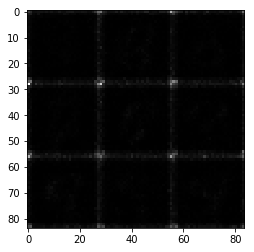

Epoch 1/2... Discriminator Loss: 1.6112... Generator Loss: 0.9136
Epoch 1/2... Discriminator Loss: 1.6081... Generator Loss: 1.2210
Epoch 1/2... Discriminator Loss: 1.5956... Generator Loss: 0.9399
Epoch 1/2... Discriminator Loss: 1.5664... Generator Loss: 0.6289
Epoch 1/2... Discriminator Loss: 2.0727... Generator Loss: 0.2481
Epoch 1/2... Discriminator Loss: 1.6513... Generator Loss: 0.4320
Epoch 1/2... Discriminator Loss: 1.6825... Generator Loss: 0.3777
Epoch 1/2... Discriminator Loss: 1.6580... Generator Loss: 0.3897
Epoch 1/2... Discriminator Loss: 1.5142... Generator Loss: 0.5039
Epoch 1/2... Discriminator Loss: 1.8253... Generator Loss: 0.3290


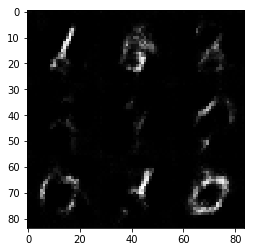

Epoch 1/2... Discriminator Loss: 1.6777... Generator Loss: 0.3790
Epoch 1/2... Discriminator Loss: 1.7685... Generator Loss: 0.4068
Epoch 1/2... Discriminator Loss: 1.8732... Generator Loss: 0.4290
Epoch 1/2... Discriminator Loss: 1.5963... Generator Loss: 0.4800
Epoch 1/2... Discriminator Loss: 1.7538... Generator Loss: 0.3826
Epoch 1/2... Discriminator Loss: 1.7355... Generator Loss: 0.3710
Epoch 1/2... Discriminator Loss: 1.7417... Generator Loss: 0.3723
Epoch 1/2... Discriminator Loss: 1.5205... Generator Loss: 0.6112
Epoch 1/2... Discriminator Loss: 1.5854... Generator Loss: 0.6112
Epoch 1/2... Discriminator Loss: 1.5254... Generator Loss: 0.7033


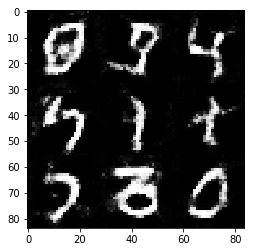

Epoch 1/2... Discriminator Loss: 1.5992... Generator Loss: 0.4177
Epoch 1/2... Discriminator Loss: 1.6291... Generator Loss: 0.5208
Epoch 1/2... Discriminator Loss: 1.4862... Generator Loss: 0.5909
Epoch 1/2... Discriminator Loss: 1.5130... Generator Loss: 0.6101
Epoch 1/2... Discriminator Loss: 1.4990... Generator Loss: 1.0544
Epoch 1/2... Discriminator Loss: 1.4978... Generator Loss: 0.8607
Epoch 1/2... Discriminator Loss: 1.5772... Generator Loss: 0.5776
Epoch 1/2... Discriminator Loss: 1.5665... Generator Loss: 0.5282
Epoch 1/2... Discriminator Loss: 1.4417... Generator Loss: 0.8498
Epoch 1/2... Discriminator Loss: 1.6405... Generator Loss: 0.7522


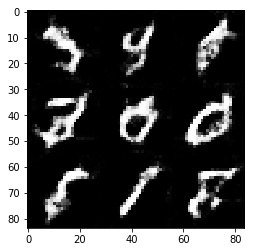

Epoch 1/2... Discriminator Loss: 1.4929... Generator Loss: 0.7258
Epoch 1/2... Discriminator Loss: 1.5072... Generator Loss: 0.8119
Epoch 1/2... Discriminator Loss: 1.5080... Generator Loss: 0.5838
Epoch 1/2... Discriminator Loss: 1.6059... Generator Loss: 0.8516
Epoch 1/2... Discriminator Loss: 1.4916... Generator Loss: 0.7906
Epoch 1/2... Discriminator Loss: 1.6892... Generator Loss: 0.5083
Epoch 1/2... Discriminator Loss: 1.6152... Generator Loss: 0.4856
Epoch 1/2... Discriminator Loss: 1.5239... Generator Loss: 0.5041
Epoch 1/2... Discriminator Loss: 1.4774... Generator Loss: 0.6005
Epoch 1/2... Discriminator Loss: 1.5052... Generator Loss: 0.7521


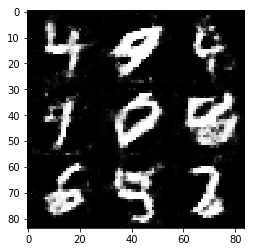

Epoch 1/2... Discriminator Loss: 1.5552... Generator Loss: 0.4761
Epoch 1/2... Discriminator Loss: 1.4937... Generator Loss: 0.7768
Epoch 1/2... Discriminator Loss: 1.5300... Generator Loss: 0.7997
Epoch 1/2... Discriminator Loss: 1.5078... Generator Loss: 0.8747
Epoch 1/2... Discriminator Loss: 1.4805... Generator Loss: 0.5738
Epoch 1/2... Discriminator Loss: 1.4169... Generator Loss: 0.7940
Epoch 1/2... Discriminator Loss: 1.5449... Generator Loss: 0.7922
Epoch 1/2... Discriminator Loss: 1.5077... Generator Loss: 0.7226
Epoch 1/2... Discriminator Loss: 1.4800... Generator Loss: 0.7196
Epoch 1/2... Discriminator Loss: 1.5549... Generator Loss: 0.5425


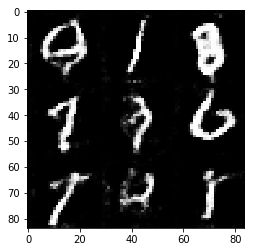

Epoch 1/2... Discriminator Loss: 1.5009... Generator Loss: 0.6064
Epoch 1/2... Discriminator Loss: 1.5947... Generator Loss: 0.4740
Epoch 1/2... Discriminator Loss: 1.4694... Generator Loss: 0.6653
Epoch 1/2... Discriminator Loss: 1.5258... Generator Loss: 0.8811
Epoch 1/2... Discriminator Loss: 1.4943... Generator Loss: 0.5785
Epoch 1/2... Discriminator Loss: 1.5675... Generator Loss: 0.5566
Epoch 1/2... Discriminator Loss: 1.5183... Generator Loss: 0.7661
Epoch 1/2... Discriminator Loss: 1.4979... Generator Loss: 0.8300
Epoch 1/2... Discriminator Loss: 1.5274... Generator Loss: 0.5393
Epoch 1/2... Discriminator Loss: 1.4125... Generator Loss: 0.7473


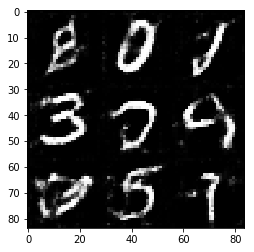

Epoch 1/2... Discriminator Loss: 1.5404... Generator Loss: 0.8700
Epoch 1/2... Discriminator Loss: 1.5077... Generator Loss: 0.8741
Epoch 1/2... Discriminator Loss: 1.5058... Generator Loss: 0.5340
Epoch 1/2... Discriminator Loss: 1.5123... Generator Loss: 0.5760
Epoch 1/2... Discriminator Loss: 1.4450... Generator Loss: 0.7282
Epoch 1/2... Discriminator Loss: 1.5162... Generator Loss: 0.7552
Epoch 1/2... Discriminator Loss: 1.5200... Generator Loss: 0.8285
Epoch 1/2... Discriminator Loss: 1.4130... Generator Loss: 0.7524
Epoch 1/2... Discriminator Loss: 1.5454... Generator Loss: 0.7491
Epoch 1/2... Discriminator Loss: 1.5827... Generator Loss: 0.6687


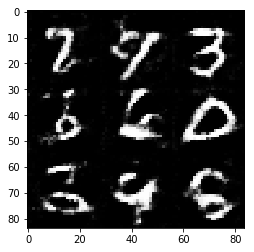

Epoch 1/2... Discriminator Loss: 1.4412... Generator Loss: 0.9168
Epoch 1/2... Discriminator Loss: 1.5074... Generator Loss: 0.7965
Epoch 1/2... Discriminator Loss: 1.5535... Generator Loss: 0.7919
Epoch 1/2... Discriminator Loss: 1.4155... Generator Loss: 0.8488
Epoch 1/2... Discriminator Loss: 1.5052... Generator Loss: 0.8268
Epoch 1/2... Discriminator Loss: 1.3487... Generator Loss: 0.8736
Epoch 1/2... Discriminator Loss: 1.5030... Generator Loss: 0.5700
Epoch 1/2... Discriminator Loss: 1.5470... Generator Loss: 0.6019
Epoch 1/2... Discriminator Loss: 1.5503... Generator Loss: 0.5560
Epoch 1/2... Discriminator Loss: 1.6561... Generator Loss: 0.3898


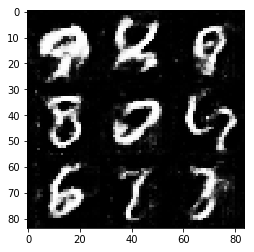

Epoch 1/2... Discriminator Loss: 1.5694... Generator Loss: 0.4920
Epoch 1/2... Discriminator Loss: 1.4705... Generator Loss: 0.7676
Epoch 1/2... Discriminator Loss: 1.4352... Generator Loss: 0.6606
Epoch 1/2... Discriminator Loss: 1.5123... Generator Loss: 0.7048
Epoch 1/2... Discriminator Loss: 1.5050... Generator Loss: 0.7517
Epoch 1/2... Discriminator Loss: 1.6188... Generator Loss: 0.4777
Epoch 1/2... Discriminator Loss: 1.5503... Generator Loss: 0.6310
Epoch 1/2... Discriminator Loss: 1.4626... Generator Loss: 0.8991
Epoch 1/2... Discriminator Loss: 1.5621... Generator Loss: 0.8363
Epoch 1/2... Discriminator Loss: 1.4820... Generator Loss: 0.6831


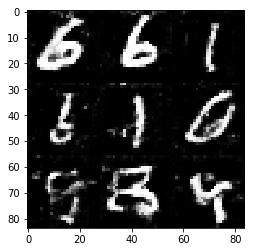

Epoch 1/2... Discriminator Loss: 1.4279... Generator Loss: 0.6679
Epoch 1/2... Discriminator Loss: 1.4889... Generator Loss: 0.5800
Epoch 1/2... Discriminator Loss: 1.4830... Generator Loss: 0.6047
Epoch 1/2... Discriminator Loss: 1.4794... Generator Loss: 0.7961
Epoch 1/2... Discriminator Loss: 1.3517... Generator Loss: 0.6932
Epoch 1/2... Discriminator Loss: 1.4018... Generator Loss: 0.7097
Epoch 1/2... Discriminator Loss: 1.4475... Generator Loss: 0.7128
Epoch 1/2... Discriminator Loss: 1.4751... Generator Loss: 0.7334
Epoch 1/2... Discriminator Loss: 1.4337... Generator Loss: 0.8931
Epoch 1/2... Discriminator Loss: 1.6316... Generator Loss: 0.5679


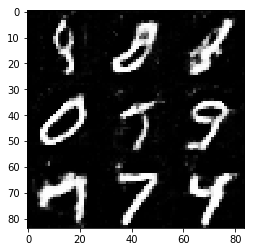

Epoch 1/2... Discriminator Loss: 1.4237... Generator Loss: 0.6694
Epoch 1/2... Discriminator Loss: 1.4963... Generator Loss: 0.6599
Epoch 1/2... Discriminator Loss: 1.4279... Generator Loss: 0.6202
Epoch 1/2... Discriminator Loss: 1.4907... Generator Loss: 0.6402
Epoch 1/2... Discriminator Loss: 1.5151... Generator Loss: 0.7435
Epoch 1/2... Discriminator Loss: 1.3856... Generator Loss: 0.8961
Epoch 1/2... Discriminator Loss: 1.4909... Generator Loss: 0.6410
Epoch 1/2... Discriminator Loss: 1.5083... Generator Loss: 0.7653
Epoch 1/2... Discriminator Loss: 1.4438... Generator Loss: 0.7040
Epoch 1/2... Discriminator Loss: 1.4253... Generator Loss: 0.9115


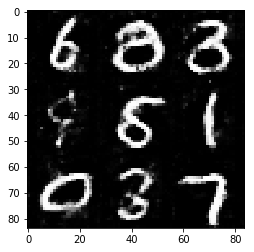

Epoch 2/2... Discriminator Loss: 1.4424... Generator Loss: 0.8486
Epoch 2/2... Discriminator Loss: 1.5303... Generator Loss: 0.5665
Epoch 2/2... Discriminator Loss: 1.5466... Generator Loss: 0.5413
Epoch 2/2... Discriminator Loss: 1.4643... Generator Loss: 0.6956
Epoch 2/2... Discriminator Loss: 1.5034... Generator Loss: 0.9228
Epoch 2/2... Discriminator Loss: 1.4836... Generator Loss: 0.6386
Epoch 2/2... Discriminator Loss: 1.4916... Generator Loss: 0.9189
Epoch 2/2... Discriminator Loss: 1.4831... Generator Loss: 0.6114
Epoch 2/2... Discriminator Loss: 1.4820... Generator Loss: 0.6863
Epoch 2/2... Discriminator Loss: 1.5020... Generator Loss: 0.5969


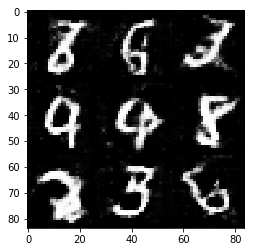

Epoch 2/2... Discriminator Loss: 1.4847... Generator Loss: 0.5871
Epoch 2/2... Discriminator Loss: 1.4999... Generator Loss: 0.6484
Epoch 2/2... Discriminator Loss: 1.5510... Generator Loss: 0.5519
Epoch 2/2... Discriminator Loss: 1.4559... Generator Loss: 0.6749
Epoch 2/2... Discriminator Loss: 1.4653... Generator Loss: 0.6283
Epoch 2/2... Discriminator Loss: 1.4935... Generator Loss: 0.6177
Epoch 2/2... Discriminator Loss: 1.5693... Generator Loss: 0.4663
Epoch 2/2... Discriminator Loss: 1.4384... Generator Loss: 0.5994
Epoch 2/2... Discriminator Loss: 1.5094... Generator Loss: 0.8298
Epoch 2/2... Discriminator Loss: 1.4799... Generator Loss: 0.9490


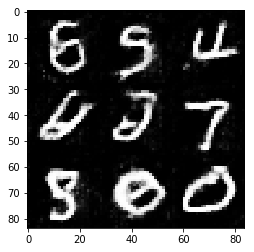

Epoch 2/2... Discriminator Loss: 1.3738... Generator Loss: 0.8260
Epoch 2/2... Discriminator Loss: 1.4971... Generator Loss: 0.5709
Epoch 2/2... Discriminator Loss: 1.4719... Generator Loss: 0.7324
Epoch 2/2... Discriminator Loss: 1.4520... Generator Loss: 0.6833
Epoch 2/2... Discriminator Loss: 1.4822... Generator Loss: 0.7180
Epoch 2/2... Discriminator Loss: 1.4708... Generator Loss: 0.6410
Epoch 2/2... Discriminator Loss: 1.4986... Generator Loss: 0.6294
Epoch 2/2... Discriminator Loss: 1.4151... Generator Loss: 0.6645
Epoch 2/2... Discriminator Loss: 1.4908... Generator Loss: 0.5957
Epoch 2/2... Discriminator Loss: 1.4383... Generator Loss: 0.7394


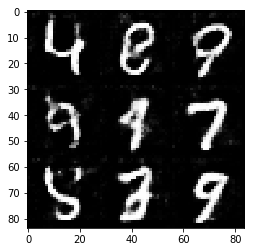

Epoch 2/2... Discriminator Loss: 1.3962... Generator Loss: 0.7872
Epoch 2/2... Discriminator Loss: 1.4269... Generator Loss: 0.8136
Epoch 2/2... Discriminator Loss: 1.4485... Generator Loss: 0.8148
Epoch 2/2... Discriminator Loss: 1.4344... Generator Loss: 0.8436
Epoch 2/2... Discriminator Loss: 1.3654... Generator Loss: 0.8055
Epoch 2/2... Discriminator Loss: 1.4049... Generator Loss: 0.9167
Epoch 2/2... Discriminator Loss: 1.4495... Generator Loss: 0.7189
Epoch 2/2... Discriminator Loss: 1.4517... Generator Loss: 0.6388
Epoch 2/2... Discriminator Loss: 1.4011... Generator Loss: 0.8457
Epoch 2/2... Discriminator Loss: 1.4101... Generator Loss: 0.7345


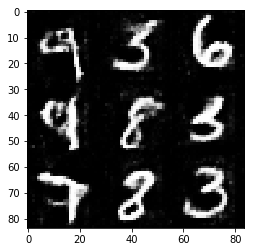

Epoch 2/2... Discriminator Loss: 1.3996... Generator Loss: 0.7870
Epoch 2/2... Discriminator Loss: 1.4687... Generator Loss: 0.5907
Epoch 2/2... Discriminator Loss: 1.4712... Generator Loss: 0.7935
Epoch 2/2... Discriminator Loss: 1.4563... Generator Loss: 0.6406
Epoch 2/2... Discriminator Loss: 1.4427... Generator Loss: 0.6681
Epoch 2/2... Discriminator Loss: 1.4794... Generator Loss: 0.7378
Epoch 2/2... Discriminator Loss: 1.4324... Generator Loss: 0.6334
Epoch 2/2... Discriminator Loss: 1.4704... Generator Loss: 0.8162
Epoch 2/2... Discriminator Loss: 1.4748... Generator Loss: 0.6951
Epoch 2/2... Discriminator Loss: 1.5013... Generator Loss: 0.6655


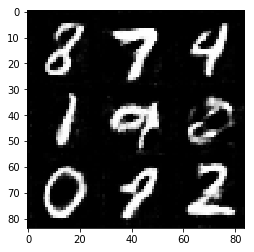

Epoch 2/2... Discriminator Loss: 1.4524... Generator Loss: 0.7409
Epoch 2/2... Discriminator Loss: 1.4489... Generator Loss: 0.5762
Epoch 2/2... Discriminator Loss: 1.4761... Generator Loss: 0.9314
Epoch 2/2... Discriminator Loss: 1.4335... Generator Loss: 0.7804
Epoch 2/2... Discriminator Loss: 1.5498... Generator Loss: 0.4714
Epoch 2/2... Discriminator Loss: 1.4254... Generator Loss: 0.6930
Epoch 2/2... Discriminator Loss: 1.5492... Generator Loss: 0.5138
Epoch 2/2... Discriminator Loss: 1.3880... Generator Loss: 0.7338
Epoch 2/2... Discriminator Loss: 1.4863... Generator Loss: 0.7089
Epoch 2/2... Discriminator Loss: 1.4903... Generator Loss: 0.8838


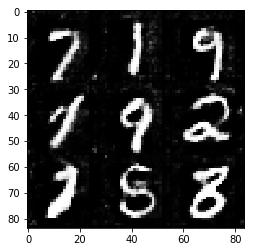

Epoch 2/2... Discriminator Loss: 1.3968... Generator Loss: 0.7185
Epoch 2/2... Discriminator Loss: 1.4423... Generator Loss: 0.6581
Epoch 2/2... Discriminator Loss: 1.4244... Generator Loss: 0.7100
Epoch 2/2... Discriminator Loss: 1.5073... Generator Loss: 0.5392
Epoch 2/2... Discriminator Loss: 1.5009... Generator Loss: 0.5266
Epoch 2/2... Discriminator Loss: 1.4762... Generator Loss: 0.6597
Epoch 2/2... Discriminator Loss: 1.4247... Generator Loss: 0.6574
Epoch 2/2... Discriminator Loss: 1.4519... Generator Loss: 0.6819
Epoch 2/2... Discriminator Loss: 1.4425... Generator Loss: 0.8792
Epoch 2/2... Discriminator Loss: 1.3955... Generator Loss: 0.6947


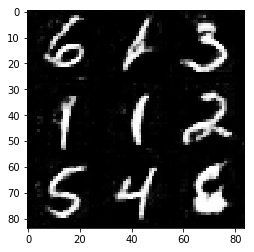

Epoch 2/2... Discriminator Loss: 1.4869... Generator Loss: 0.6080
Epoch 2/2... Discriminator Loss: 1.4325... Generator Loss: 0.8449
Epoch 2/2... Discriminator Loss: 1.5598... Generator Loss: 0.5456
Epoch 2/2... Discriminator Loss: 1.4456... Generator Loss: 0.6679
Epoch 2/2... Discriminator Loss: 1.3802... Generator Loss: 0.8164
Epoch 2/2... Discriminator Loss: 1.4175... Generator Loss: 0.6946
Epoch 2/2... Discriminator Loss: 1.4378... Generator Loss: 0.8445
Epoch 2/2... Discriminator Loss: 1.4276... Generator Loss: 0.7676
Epoch 2/2... Discriminator Loss: 1.4500... Generator Loss: 0.6251
Epoch 2/2... Discriminator Loss: 1.4795... Generator Loss: 0.5855


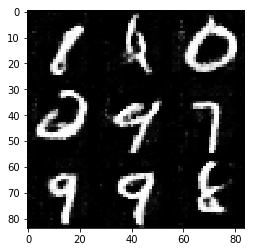

Epoch 2/2... Discriminator Loss: 1.4335... Generator Loss: 0.6807
Epoch 2/2... Discriminator Loss: 1.4625... Generator Loss: 0.7598
Epoch 2/2... Discriminator Loss: 1.4378... Generator Loss: 0.8088
Epoch 2/2... Discriminator Loss: 1.4255... Generator Loss: 0.8426
Epoch 2/2... Discriminator Loss: 1.4972... Generator Loss: 0.6791
Epoch 2/2... Discriminator Loss: 1.4244... Generator Loss: 0.8192
Epoch 2/2... Discriminator Loss: 1.4342... Generator Loss: 0.5786
Epoch 2/2... Discriminator Loss: 1.3856... Generator Loss: 0.8271
Epoch 2/2... Discriminator Loss: 1.4377... Generator Loss: 0.6062
Epoch 2/2... Discriminator Loss: 1.5067... Generator Loss: 0.5146


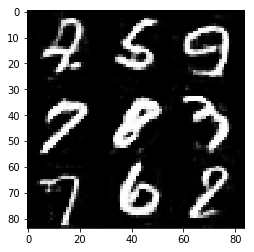

Epoch 2/2... Discriminator Loss: 1.4646... Generator Loss: 0.7457
Epoch 2/2... Discriminator Loss: 1.4694... Generator Loss: 0.6584
Epoch 2/2... Discriminator Loss: 1.4406... Generator Loss: 0.7943
Epoch 2/2... Discriminator Loss: 1.5017... Generator Loss: 0.7533
Epoch 2/2... Discriminator Loss: 1.4319... Generator Loss: 0.6671
Epoch 2/2... Discriminator Loss: 1.4471... Generator Loss: 0.8370
Epoch 2/2... Discriminator Loss: 1.4675... Generator Loss: 0.7671
Epoch 2/2... Discriminator Loss: 1.4353... Generator Loss: 0.8489
Epoch 2/2... Discriminator Loss: 1.4144... Generator Loss: 0.6951
Epoch 2/2... Discriminator Loss: 1.3748... Generator Loss: 0.6410


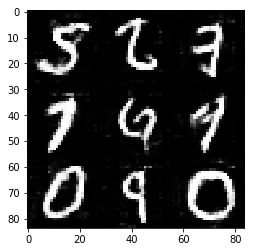

Epoch 2/2... Discriminator Loss: 1.3944... Generator Loss: 0.7189
Epoch 2/2... Discriminator Loss: 1.3599... Generator Loss: 0.7574
Epoch 2/2... Discriminator Loss: 1.4426... Generator Loss: 0.8606
Epoch 2/2... Discriminator Loss: 1.3985... Generator Loss: 0.8541
Epoch 2/2... Discriminator Loss: 1.3338... Generator Loss: 0.8006
Epoch 2/2... Discriminator Loss: 1.4402... Generator Loss: 0.6793
Epoch 2/2... Discriminator Loss: 1.4607... Generator Loss: 0.8621
Epoch 2/2... Discriminator Loss: 1.4254... Generator Loss: 0.7517
Epoch 2/2... Discriminator Loss: 1.4010... Generator Loss: 0.7230
Epoch 2/2... Discriminator Loss: 1.4581... Generator Loss: 0.6958


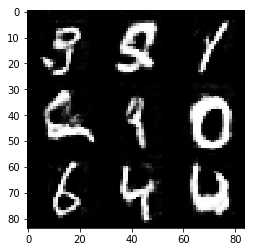

Epoch 2/2... Discriminator Loss: 1.4058... Generator Loss: 0.6716
Epoch 2/2... Discriminator Loss: 1.4167... Generator Loss: 0.9516
Epoch 2/2... Discriminator Loss: 1.3882... Generator Loss: 0.9054
Epoch 2/2... Discriminator Loss: 1.4020... Generator Loss: 0.7009
Epoch 2/2... Discriminator Loss: 1.3813... Generator Loss: 0.8407
Epoch 2/2... Discriminator Loss: 1.3909... Generator Loss: 0.7413
Epoch 2/2... Discriminator Loss: 1.5083... Generator Loss: 0.5854
Epoch 2/2... Discriminator Loss: 1.5492... Generator Loss: 0.4552
Epoch 2/2... Discriminator Loss: 1.4831... Generator Loss: 0.5797
Epoch 2/2... Discriminator Loss: 1.3492... Generator Loss: 0.7110


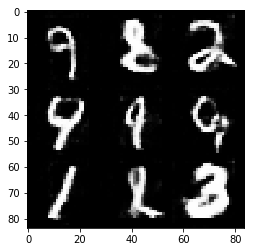

In [13]:
batch_size = 50
z_dim = 100
learning_rate = 0.0002
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))

with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.0984... Generator Loss: 0.8675
Epoch 1/1... Discriminator Loss: 4.6046... Generator Loss: 0.0249
Epoch 1/1... Discriminator Loss: 2.0468... Generator Loss: 1.3094
Epoch 1/1... Discriminator Loss: 1.5112... Generator Loss: 0.7771
Epoch 1/1... Discriminator Loss: 1.3621... Generator Loss: 2.0901
Epoch 1/1... Discriminator Loss: 1.4032... Generator Loss: 1.8209
Epoch 1/1... Discriminator Loss: 2.0745... Generator Loss: 1.1609
Epoch 1/1... Discriminator Loss: 1.6275... Generator Loss: 0.7440
Epoch 1/1... Discriminator Loss: 1.4994... Generator Loss: 0.8573
Epoch 1/1... Discriminator Loss: 1.7183... Generator Loss: 1.2798


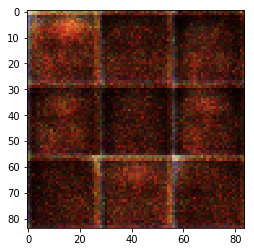

Epoch 1/1... Discriminator Loss: 1.6518... Generator Loss: 0.9280
Epoch 1/1... Discriminator Loss: 1.6698... Generator Loss: 0.6438
Epoch 1/1... Discriminator Loss: 1.7965... Generator Loss: 0.6864
Epoch 1/1... Discriminator Loss: 1.9375... Generator Loss: 1.1839
Epoch 1/1... Discriminator Loss: 1.8312... Generator Loss: 0.5454
Epoch 1/1... Discriminator Loss: 1.5617... Generator Loss: 0.7690
Epoch 1/1... Discriminator Loss: 1.7832... Generator Loss: 0.8246
Epoch 1/1... Discriminator Loss: 1.6836... Generator Loss: 0.8000
Epoch 1/1... Discriminator Loss: 1.6988... Generator Loss: 0.5591
Epoch 1/1... Discriminator Loss: 1.8312... Generator Loss: 0.3362


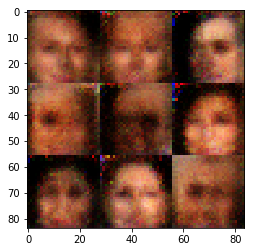

Epoch 1/1... Discriminator Loss: 1.4684... Generator Loss: 0.6757
Epoch 1/1... Discriminator Loss: 1.5914... Generator Loss: 0.9493
Epoch 1/1... Discriminator Loss: 1.6313... Generator Loss: 0.7469
Epoch 1/1... Discriminator Loss: 1.5568... Generator Loss: 0.6124
Epoch 1/1... Discriminator Loss: 1.6799... Generator Loss: 0.4383
Epoch 1/1... Discriminator Loss: 1.5411... Generator Loss: 0.4707
Epoch 1/1... Discriminator Loss: 1.4797... Generator Loss: 0.7622
Epoch 1/1... Discriminator Loss: 1.6082... Generator Loss: 0.6812
Epoch 1/1... Discriminator Loss: 1.5390... Generator Loss: 0.7201
Epoch 1/1... Discriminator Loss: 1.6332... Generator Loss: 0.5882


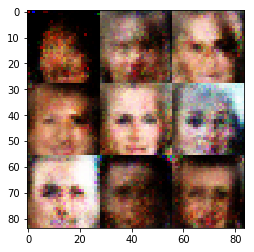

Epoch 1/1... Discriminator Loss: 1.8177... Generator Loss: 0.3692
Epoch 1/1... Discriminator Loss: 1.4742... Generator Loss: 0.8140
Epoch 1/1... Discriminator Loss: 1.5719... Generator Loss: 0.6826
Epoch 1/1... Discriminator Loss: 1.6897... Generator Loss: 0.4583
Epoch 1/1... Discriminator Loss: 1.6039... Generator Loss: 0.7383
Epoch 1/1... Discriminator Loss: 1.5273... Generator Loss: 0.6749
Epoch 1/1... Discriminator Loss: 1.5149... Generator Loss: 0.6207
Epoch 1/1... Discriminator Loss: 1.6166... Generator Loss: 0.7295
Epoch 1/1... Discriminator Loss: 1.5786... Generator Loss: 0.5884
Epoch 1/1... Discriminator Loss: 1.5039... Generator Loss: 0.7829


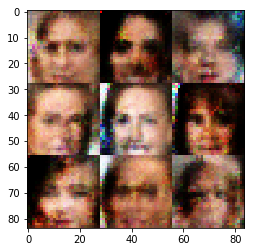

Epoch 1/1... Discriminator Loss: 1.5426... Generator Loss: 0.6511
Epoch 1/1... Discriminator Loss: 1.5545... Generator Loss: 0.6924
Epoch 1/1... Discriminator Loss: 1.5571... Generator Loss: 0.5622
Epoch 1/1... Discriminator Loss: 1.5598... Generator Loss: 0.6875
Epoch 1/1... Discriminator Loss: 1.5058... Generator Loss: 0.7202
Epoch 1/1... Discriminator Loss: 1.5816... Generator Loss: 0.8689
Epoch 1/1... Discriminator Loss: 1.4952... Generator Loss: 0.6606
Epoch 1/1... Discriminator Loss: 1.5737... Generator Loss: 0.8433
Epoch 1/1... Discriminator Loss: 1.5351... Generator Loss: 0.6695
Epoch 1/1... Discriminator Loss: 1.5357... Generator Loss: 0.6336


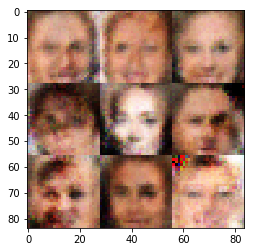

Epoch 1/1... Discriminator Loss: 1.4798... Generator Loss: 0.7081
Epoch 1/1... Discriminator Loss: 1.5136... Generator Loss: 0.6790
Epoch 1/1... Discriminator Loss: 1.4678... Generator Loss: 0.7203
Epoch 1/1... Discriminator Loss: 1.5129... Generator Loss: 0.6481
Epoch 1/1... Discriminator Loss: 1.4946... Generator Loss: 0.7696
Epoch 1/1... Discriminator Loss: 1.5921... Generator Loss: 0.6643
Epoch 1/1... Discriminator Loss: 1.5953... Generator Loss: 0.6237
Epoch 1/1... Discriminator Loss: 1.5288... Generator Loss: 0.7939
Epoch 1/1... Discriminator Loss: 1.5146... Generator Loss: 0.7690
Epoch 1/1... Discriminator Loss: 1.5094... Generator Loss: 0.7444


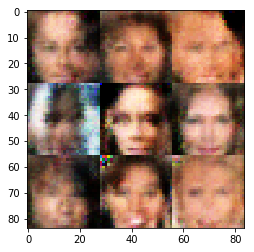

Epoch 1/1... Discriminator Loss: 1.5002... Generator Loss: 0.6832
Epoch 1/1... Discriminator Loss: 1.5339... Generator Loss: 0.5661
Epoch 1/1... Discriminator Loss: 1.4747... Generator Loss: 0.7785
Epoch 1/1... Discriminator Loss: 1.4769... Generator Loss: 0.7476
Epoch 1/1... Discriminator Loss: 1.4865... Generator Loss: 0.7382
Epoch 1/1... Discriminator Loss: 1.5025... Generator Loss: 0.6048
Epoch 1/1... Discriminator Loss: 1.4528... Generator Loss: 0.6684
Epoch 1/1... Discriminator Loss: 1.4766... Generator Loss: 0.8342
Epoch 1/1... Discriminator Loss: 1.4136... Generator Loss: 0.6580
Epoch 1/1... Discriminator Loss: 1.4841... Generator Loss: 0.7473


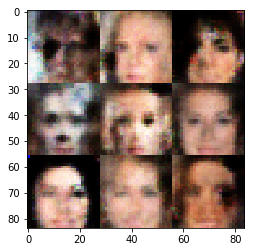

Epoch 1/1... Discriminator Loss: 1.5327... Generator Loss: 0.6333
Epoch 1/1... Discriminator Loss: 1.4955... Generator Loss: 0.7591
Epoch 1/1... Discriminator Loss: 1.4636... Generator Loss: 0.7259
Epoch 1/1... Discriminator Loss: 1.4291... Generator Loss: 0.7839
Epoch 1/1... Discriminator Loss: 1.4925... Generator Loss: 0.6992
Epoch 1/1... Discriminator Loss: 1.4579... Generator Loss: 0.6809
Epoch 1/1... Discriminator Loss: 1.4770... Generator Loss: 0.8435
Epoch 1/1... Discriminator Loss: 1.4797... Generator Loss: 0.7480
Epoch 1/1... Discriminator Loss: 1.5082... Generator Loss: 0.6630
Epoch 1/1... Discriminator Loss: 1.4332... Generator Loss: 0.8706


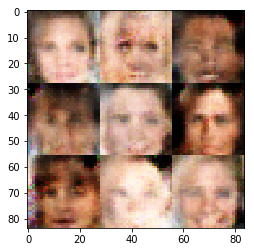

Epoch 1/1... Discriminator Loss: 1.4831... Generator Loss: 0.7701
Epoch 1/1... Discriminator Loss: 1.4442... Generator Loss: 0.7564
Epoch 1/1... Discriminator Loss: 1.5090... Generator Loss: 0.8180
Epoch 1/1... Discriminator Loss: 1.5691... Generator Loss: 0.6981
Epoch 1/1... Discriminator Loss: 1.4920... Generator Loss: 0.6159
Epoch 1/1... Discriminator Loss: 1.4545... Generator Loss: 0.6633
Epoch 1/1... Discriminator Loss: 1.4493... Generator Loss: 0.6284
Epoch 1/1... Discriminator Loss: 1.4114... Generator Loss: 0.7980
Epoch 1/1... Discriminator Loss: 1.4220... Generator Loss: 0.7051
Epoch 1/1... Discriminator Loss: 1.4951... Generator Loss: 0.8490


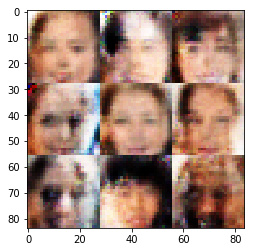

Epoch 1/1... Discriminator Loss: 1.4626... Generator Loss: 0.8255
Epoch 1/1... Discriminator Loss: 1.4521... Generator Loss: 0.7521
Epoch 1/1... Discriminator Loss: 1.4684... Generator Loss: 0.7197
Epoch 1/1... Discriminator Loss: 1.4925... Generator Loss: 0.7533
Epoch 1/1... Discriminator Loss: 1.5007... Generator Loss: 0.8649
Epoch 1/1... Discriminator Loss: 1.5081... Generator Loss: 0.6624
Epoch 1/1... Discriminator Loss: 1.5082... Generator Loss: 0.6736
Epoch 1/1... Discriminator Loss: 1.4520... Generator Loss: 0.7366
Epoch 1/1... Discriminator Loss: 1.4065... Generator Loss: 0.8884
Epoch 1/1... Discriminator Loss: 1.4314... Generator Loss: 0.7737


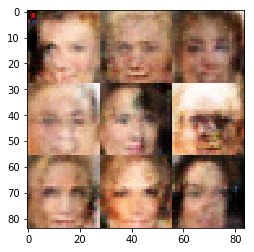

Epoch 1/1... Discriminator Loss: 1.4771... Generator Loss: 0.8535
Epoch 1/1... Discriminator Loss: 1.3645... Generator Loss: 0.7691
Epoch 1/1... Discriminator Loss: 1.4526... Generator Loss: 0.7354
Epoch 1/1... Discriminator Loss: 1.4449... Generator Loss: 0.7326
Epoch 1/1... Discriminator Loss: 1.4570... Generator Loss: 0.7588
Epoch 1/1... Discriminator Loss: 1.4362... Generator Loss: 0.7701
Epoch 1/1... Discriminator Loss: 1.4923... Generator Loss: 0.6946
Epoch 1/1... Discriminator Loss: 1.4513... Generator Loss: 0.8083
Epoch 1/1... Discriminator Loss: 1.4741... Generator Loss: 0.7774
Epoch 1/1... Discriminator Loss: 1.4820... Generator Loss: 0.6603


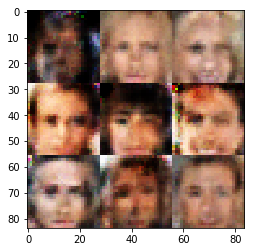

Epoch 1/1... Discriminator Loss: 1.4561... Generator Loss: 0.7452
Epoch 1/1... Discriminator Loss: 1.4001... Generator Loss: 0.7046
Epoch 1/1... Discriminator Loss: 1.4895... Generator Loss: 0.6677
Epoch 1/1... Discriminator Loss: 1.4887... Generator Loss: 0.7323
Epoch 1/1... Discriminator Loss: 1.4194... Generator Loss: 0.6879
Epoch 1/1... Discriminator Loss: 1.4540... Generator Loss: 0.7822
Epoch 1/1... Discriminator Loss: 1.4033... Generator Loss: 0.8788
Epoch 1/1... Discriminator Loss: 1.4914... Generator Loss: 0.6783
Epoch 1/1... Discriminator Loss: 1.4657... Generator Loss: 0.7176
Epoch 1/1... Discriminator Loss: 1.4151... Generator Loss: 0.8170


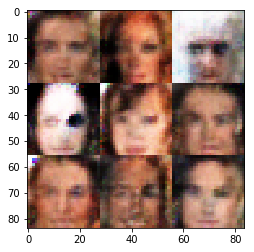

Epoch 1/1... Discriminator Loss: 1.4458... Generator Loss: 0.7925
Epoch 1/1... Discriminator Loss: 1.4521... Generator Loss: 0.6879
Epoch 1/1... Discriminator Loss: 1.4805... Generator Loss: 0.8098
Epoch 1/1... Discriminator Loss: 1.4448... Generator Loss: 0.7803
Epoch 1/1... Discriminator Loss: 1.4540... Generator Loss: 0.6779
Epoch 1/1... Discriminator Loss: 1.4237... Generator Loss: 0.7902
Epoch 1/1... Discriminator Loss: 1.4350... Generator Loss: 0.8073
Epoch 1/1... Discriminator Loss: 1.4609... Generator Loss: 0.7333
Epoch 1/1... Discriminator Loss: 1.4487... Generator Loss: 0.7673
Epoch 1/1... Discriminator Loss: 1.4445... Generator Loss: 0.6196


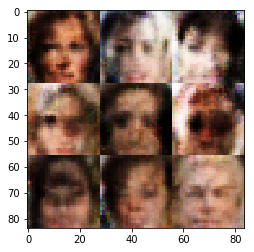

Epoch 1/1... Discriminator Loss: 1.4981... Generator Loss: 0.6646
Epoch 1/1... Discriminator Loss: 1.5170... Generator Loss: 0.7466
Epoch 1/1... Discriminator Loss: 1.4542... Generator Loss: 0.7218
Epoch 1/1... Discriminator Loss: 1.4011... Generator Loss: 0.6875
Epoch 1/1... Discriminator Loss: 1.4021... Generator Loss: 0.8310
Epoch 1/1... Discriminator Loss: 1.4207... Generator Loss: 0.6586
Epoch 1/1... Discriminator Loss: 1.4489... Generator Loss: 0.8255
Epoch 1/1... Discriminator Loss: 1.4699... Generator Loss: 0.6520
Epoch 1/1... Discriminator Loss: 1.4381... Generator Loss: 0.8110
Epoch 1/1... Discriminator Loss: 1.4106... Generator Loss: 0.7117


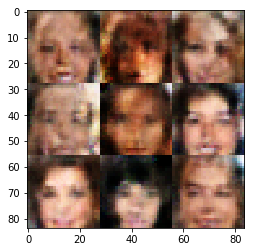

Epoch 1/1... Discriminator Loss: 1.3967... Generator Loss: 0.8397
Epoch 1/1... Discriminator Loss: 1.4977... Generator Loss: 0.7115
Epoch 1/1... Discriminator Loss: 1.4655... Generator Loss: 0.7758
Epoch 1/1... Discriminator Loss: 1.4596... Generator Loss: 0.7375
Epoch 1/1... Discriminator Loss: 1.4308... Generator Loss: 0.7915
Epoch 1/1... Discriminator Loss: 1.4523... Generator Loss: 0.6828
Epoch 1/1... Discriminator Loss: 1.4614... Generator Loss: 0.7552
Epoch 1/1... Discriminator Loss: 1.4481... Generator Loss: 0.7859
Epoch 1/1... Discriminator Loss: 1.4006... Generator Loss: 0.7137
Epoch 1/1... Discriminator Loss: 1.4200... Generator Loss: 0.6628


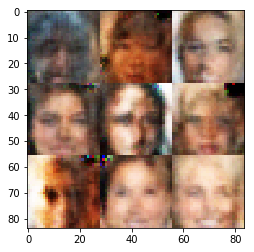

Epoch 1/1... Discriminator Loss: 1.4129... Generator Loss: 0.7871
Epoch 1/1... Discriminator Loss: 1.3981... Generator Loss: 0.7349
Epoch 1/1... Discriminator Loss: 1.4247... Generator Loss: 0.7430
Epoch 1/1... Discriminator Loss: 1.4086... Generator Loss: 0.7169
Epoch 1/1... Discriminator Loss: 1.4537... Generator Loss: 0.7119
Epoch 1/1... Discriminator Loss: 1.4755... Generator Loss: 0.8426
Epoch 1/1... Discriminator Loss: 1.4519... Generator Loss: 0.7690
Epoch 1/1... Discriminator Loss: 1.4309... Generator Loss: 0.8836
Epoch 1/1... Discriminator Loss: 1.4159... Generator Loss: 0.8822
Epoch 1/1... Discriminator Loss: 1.4222... Generator Loss: 0.7493


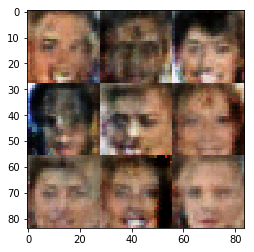

Epoch 1/1... Discriminator Loss: 1.4346... Generator Loss: 0.7014
Epoch 1/1... Discriminator Loss: 1.4573... Generator Loss: 0.7737
Epoch 1/1... Discriminator Loss: 1.4690... Generator Loss: 0.7923
Epoch 1/1... Discriminator Loss: 1.3971... Generator Loss: 0.6883
Epoch 1/1... Discriminator Loss: 1.4234... Generator Loss: 0.7889
Epoch 1/1... Discriminator Loss: 1.4224... Generator Loss: 0.7243
Epoch 1/1... Discriminator Loss: 1.4210... Generator Loss: 0.7412
Epoch 1/1... Discriminator Loss: 1.4487... Generator Loss: 0.8163
Epoch 1/1... Discriminator Loss: 1.4449... Generator Loss: 0.6675
Epoch 1/1... Discriminator Loss: 1.4237... Generator Loss: 0.8236


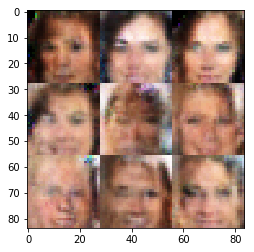

Epoch 1/1... Discriminator Loss: 1.4329... Generator Loss: 0.8596
Epoch 1/1... Discriminator Loss: 1.4159... Generator Loss: 0.6493
Epoch 1/1... Discriminator Loss: 1.4590... Generator Loss: 0.7762
Epoch 1/1... Discriminator Loss: 1.4044... Generator Loss: 0.7941
Epoch 1/1... Discriminator Loss: 1.4225... Generator Loss: 0.7689
Epoch 1/1... Discriminator Loss: 1.4395... Generator Loss: 0.7125
Epoch 1/1... Discriminator Loss: 1.4058... Generator Loss: 0.7976
Epoch 1/1... Discriminator Loss: 1.4342... Generator Loss: 0.7537
Epoch 1/1... Discriminator Loss: 1.4733... Generator Loss: 0.6983
Epoch 1/1... Discriminator Loss: 1.4186... Generator Loss: 0.7702


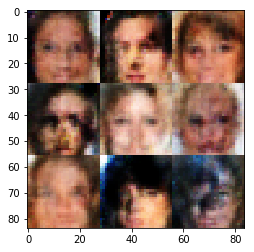

Epoch 1/1... Discriminator Loss: 1.4427... Generator Loss: 0.7952
Epoch 1/1... Discriminator Loss: 1.4636... Generator Loss: 0.7140
Epoch 1/1... Discriminator Loss: 1.4622... Generator Loss: 0.7081
Epoch 1/1... Discriminator Loss: 1.4095... Generator Loss: 0.7228
Epoch 1/1... Discriminator Loss: 1.3889... Generator Loss: 0.8290
Epoch 1/1... Discriminator Loss: 1.4623... Generator Loss: 0.7752
Epoch 1/1... Discriminator Loss: 1.4448... Generator Loss: 0.7602
Epoch 1/1... Discriminator Loss: 1.4310... Generator Loss: 0.8574
Epoch 1/1... Discriminator Loss: 1.4475... Generator Loss: 0.7216
Epoch 1/1... Discriminator Loss: 1.3977... Generator Loss: 0.7305


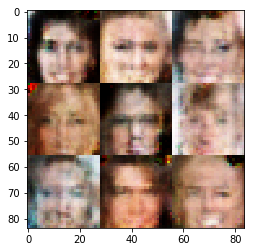

Epoch 1/1... Discriminator Loss: 1.4357... Generator Loss: 0.7398
Epoch 1/1... Discriminator Loss: 1.4474... Generator Loss: 0.7624
Epoch 1/1... Discriminator Loss: 1.3792... Generator Loss: 0.7968
Epoch 1/1... Discriminator Loss: 1.4502... Generator Loss: 0.7691
Epoch 1/1... Discriminator Loss: 1.4641... Generator Loss: 0.7396
Epoch 1/1... Discriminator Loss: 1.4563... Generator Loss: 0.7582
Epoch 1/1... Discriminator Loss: 1.4314... Generator Loss: 0.7876
Epoch 1/1... Discriminator Loss: 1.4743... Generator Loss: 0.7111
Epoch 1/1... Discriminator Loss: 1.4466... Generator Loss: 0.8225
Epoch 1/1... Discriminator Loss: 1.4246... Generator Loss: 0.7006


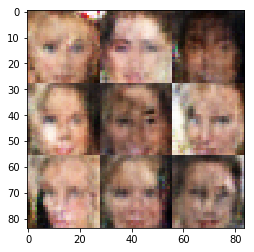

Epoch 1/1... Discriminator Loss: 1.4673... Generator Loss: 0.7317
Epoch 1/1... Discriminator Loss: 1.4746... Generator Loss: 0.8385
Epoch 1/1... Discriminator Loss: 1.3889... Generator Loss: 0.8716
Epoch 1/1... Discriminator Loss: 1.4453... Generator Loss: 0.8009
Epoch 1/1... Discriminator Loss: 1.4193... Generator Loss: 0.7672
Epoch 1/1... Discriminator Loss: 1.4266... Generator Loss: 0.7757
Epoch 1/1... Discriminator Loss: 1.4050... Generator Loss: 0.8521
Epoch 1/1... Discriminator Loss: 1.4081... Generator Loss: 0.7778
Epoch 1/1... Discriminator Loss: 1.4690... Generator Loss: 0.7589
Epoch 1/1... Discriminator Loss: 1.4166... Generator Loss: 0.8266


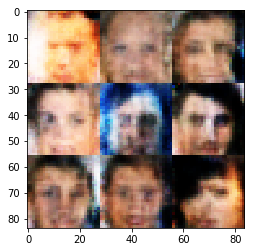

Epoch 1/1... Discriminator Loss: 1.3615... Generator Loss: 0.7055
Epoch 1/1... Discriminator Loss: 1.4417... Generator Loss: 0.8155
Epoch 1/1... Discriminator Loss: 1.4653... Generator Loss: 0.7409
Epoch 1/1... Discriminator Loss: 1.4300... Generator Loss: 0.7487
Epoch 1/1... Discriminator Loss: 1.4181... Generator Loss: 0.7456
Epoch 1/1... Discriminator Loss: 1.4148... Generator Loss: 0.7456
Epoch 1/1... Discriminator Loss: 1.4450... Generator Loss: 0.7233
Epoch 1/1... Discriminator Loss: 1.4027... Generator Loss: 0.8224
Epoch 1/1... Discriminator Loss: 1.4176... Generator Loss: 0.6473
Epoch 1/1... Discriminator Loss: 1.4233... Generator Loss: 0.7478


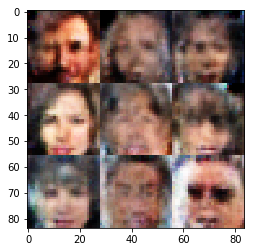

Epoch 1/1... Discriminator Loss: 1.4013... Generator Loss: 0.7295
Epoch 1/1... Discriminator Loss: 1.4333... Generator Loss: 0.7352
Epoch 1/1... Discriminator Loss: 1.4102... Generator Loss: 0.7713
Epoch 1/1... Discriminator Loss: 1.4321... Generator Loss: 0.7864
Epoch 1/1... Discriminator Loss: 1.3802... Generator Loss: 0.7556
Epoch 1/1... Discriminator Loss: 1.4297... Generator Loss: 0.7200
Epoch 1/1... Discriminator Loss: 1.4360... Generator Loss: 0.8159
Epoch 1/1... Discriminator Loss: 1.4225... Generator Loss: 0.7133
Epoch 1/1... Discriminator Loss: 1.4423... Generator Loss: 0.7536
Epoch 1/1... Discriminator Loss: 1.3795... Generator Loss: 0.7670


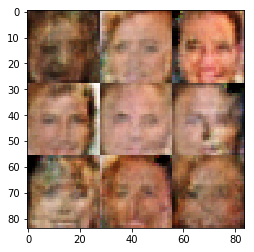

Epoch 1/1... Discriminator Loss: 1.3983... Generator Loss: 0.7882
Epoch 1/1... Discriminator Loss: 1.4552... Generator Loss: 0.6654
Epoch 1/1... Discriminator Loss: 1.4179... Generator Loss: 0.6820
Epoch 1/1... Discriminator Loss: 1.4328... Generator Loss: 0.7996
Epoch 1/1... Discriminator Loss: 1.4216... Generator Loss: 0.7073
Epoch 1/1... Discriminator Loss: 1.4494... Generator Loss: 0.7000
Epoch 1/1... Discriminator Loss: 1.4180... Generator Loss: 0.7578
Epoch 1/1... Discriminator Loss: 1.4290... Generator Loss: 0.7143
Epoch 1/1... Discriminator Loss: 1.4047... Generator Loss: 0.7730
Epoch 1/1... Discriminator Loss: 1.4220... Generator Loss: 0.8216


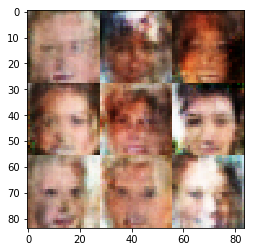

Epoch 1/1... Discriminator Loss: 1.4097... Generator Loss: 0.7813
Epoch 1/1... Discriminator Loss: 1.4249... Generator Loss: 0.8337
Epoch 1/1... Discriminator Loss: 1.4067... Generator Loss: 0.7844
Epoch 1/1... Discriminator Loss: 1.4385... Generator Loss: 0.7230
Epoch 1/1... Discriminator Loss: 1.4359... Generator Loss: 0.8761
Epoch 1/1... Discriminator Loss: 1.4013... Generator Loss: 0.8425
Epoch 1/1... Discriminator Loss: 1.4307... Generator Loss: 0.7676
Epoch 1/1... Discriminator Loss: 1.4386... Generator Loss: 0.7758
Epoch 1/1... Discriminator Loss: 1.4201... Generator Loss: 0.7796
Epoch 1/1... Discriminator Loss: 1.4129... Generator Loss: 0.7496


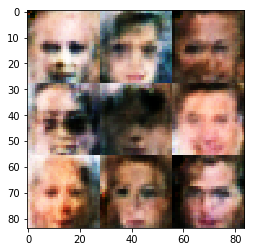

Epoch 1/1... Discriminator Loss: 1.4407... Generator Loss: 0.6893
Epoch 1/1... Discriminator Loss: 1.4436... Generator Loss: 0.7623
Epoch 1/1... Discriminator Loss: 1.3827... Generator Loss: 0.8495
Epoch 1/1... Discriminator Loss: 1.4164... Generator Loss: 0.8019
Epoch 1/1... Discriminator Loss: 1.4142... Generator Loss: 0.7651
Epoch 1/1... Discriminator Loss: 1.3766... Generator Loss: 0.8378
Epoch 1/1... Discriminator Loss: 1.4227... Generator Loss: 0.6694
Epoch 1/1... Discriminator Loss: 1.4409... Generator Loss: 0.7669
Epoch 1/1... Discriminator Loss: 1.3951... Generator Loss: 0.7587
Epoch 1/1... Discriminator Loss: 1.4144... Generator Loss: 0.7502


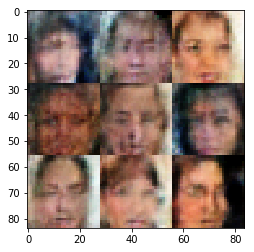

Epoch 1/1... Discriminator Loss: 1.4111... Generator Loss: 0.7447
Epoch 1/1... Discriminator Loss: 1.4152... Generator Loss: 0.7243
Epoch 1/1... Discriminator Loss: 1.4151... Generator Loss: 0.7924
Epoch 1/1... Discriminator Loss: 1.4793... Generator Loss: 0.5799
Epoch 1/1... Discriminator Loss: 1.4020... Generator Loss: 0.8596
Epoch 1/1... Discriminator Loss: 1.4243... Generator Loss: 0.7816
Epoch 1/1... Discriminator Loss: 1.3871... Generator Loss: 0.7649
Epoch 1/1... Discriminator Loss: 1.4324... Generator Loss: 0.6780
Epoch 1/1... Discriminator Loss: 1.4170... Generator Loss: 0.7048
Epoch 1/1... Discriminator Loss: 1.4354... Generator Loss: 0.7657


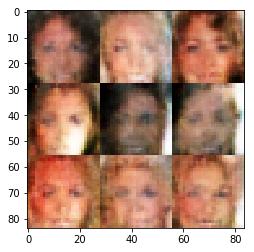

Epoch 1/1... Discriminator Loss: 1.3964... Generator Loss: 0.7380
Epoch 1/1... Discriminator Loss: 1.4270... Generator Loss: 0.7344
Epoch 1/1... Discriminator Loss: 1.4307... Generator Loss: 0.7922
Epoch 1/1... Discriminator Loss: 1.4625... Generator Loss: 0.6533
Epoch 1/1... Discriminator Loss: 1.4429... Generator Loss: 0.6951
Epoch 1/1... Discriminator Loss: 1.3871... Generator Loss: 0.8024
Epoch 1/1... Discriminator Loss: 1.4349... Generator Loss: 0.7960
Epoch 1/1... Discriminator Loss: 1.4049... Generator Loss: 0.8084
Epoch 1/1... Discriminator Loss: 1.4362... Generator Loss: 0.7147
Epoch 1/1... Discriminator Loss: 1.4051... Generator Loss: 0.7413


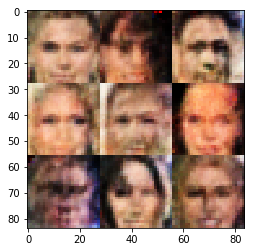

Epoch 1/1... Discriminator Loss: 1.4098... Generator Loss: 0.7866
Epoch 1/1... Discriminator Loss: 1.4098... Generator Loss: 0.7068
Epoch 1/1... Discriminator Loss: 1.4128... Generator Loss: 0.7280
Epoch 1/1... Discriminator Loss: 1.4685... Generator Loss: 0.8700
Epoch 1/1... Discriminator Loss: 1.4006... Generator Loss: 0.7389
Epoch 1/1... Discriminator Loss: 1.4746... Generator Loss: 0.7128
Epoch 1/1... Discriminator Loss: 1.4097... Generator Loss: 0.7047
Epoch 1/1... Discriminator Loss: 1.3901... Generator Loss: 0.7077
Epoch 1/1... Discriminator Loss: 1.4171... Generator Loss: 0.7564
Epoch 1/1... Discriminator Loss: 1.4046... Generator Loss: 0.7904


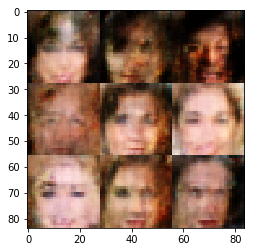

Epoch 1/1... Discriminator Loss: 1.4047... Generator Loss: 0.8048
Epoch 1/1... Discriminator Loss: 1.4179... Generator Loss: 0.7321
Epoch 1/1... Discriminator Loss: 1.4382... Generator Loss: 0.7199
Epoch 1/1... Discriminator Loss: 1.4700... Generator Loss: 0.6710
Epoch 1/1... Discriminator Loss: 1.3937... Generator Loss: 0.8367
Epoch 1/1... Discriminator Loss: 1.4293... Generator Loss: 0.7302
Epoch 1/1... Discriminator Loss: 1.4040... Generator Loss: 0.8038
Epoch 1/1... Discriminator Loss: 1.4174... Generator Loss: 0.7509
Epoch 1/1... Discriminator Loss: 1.3821... Generator Loss: 0.8311
Epoch 1/1... Discriminator Loss: 1.3962... Generator Loss: 0.8262


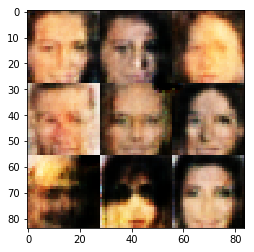

Epoch 1/1... Discriminator Loss: 1.4296... Generator Loss: 0.7346
Epoch 1/1... Discriminator Loss: 1.3941... Generator Loss: 0.7532
Epoch 1/1... Discriminator Loss: 1.4078... Generator Loss: 0.7235
Epoch 1/1... Discriminator Loss: 1.4156... Generator Loss: 0.7380
Epoch 1/1... Discriminator Loss: 1.4496... Generator Loss: 0.7502
Epoch 1/1... Discriminator Loss: 1.4149... Generator Loss: 0.8017
Epoch 1/1... Discriminator Loss: 1.4074... Generator Loss: 0.7997
Epoch 1/1... Discriminator Loss: 1.4264... Generator Loss: 0.8134
Epoch 1/1... Discriminator Loss: 1.4187... Generator Loss: 0.8154
Epoch 1/1... Discriminator Loss: 1.4204... Generator Loss: 0.7993


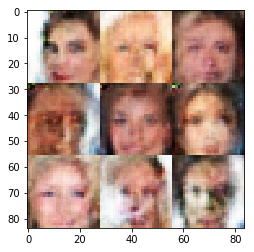

Epoch 1/1... Discriminator Loss: 1.3981... Generator Loss: 0.8424
Epoch 1/1... Discriminator Loss: 1.4349... Generator Loss: 0.6852
Epoch 1/1... Discriminator Loss: 1.3961... Generator Loss: 0.7418
Epoch 1/1... Discriminator Loss: 1.4483... Generator Loss: 0.8516
Epoch 1/1... Discriminator Loss: 1.4235... Generator Loss: 0.7724
Epoch 1/1... Discriminator Loss: 1.4192... Generator Loss: 0.6485
Epoch 1/1... Discriminator Loss: 1.4036... Generator Loss: 0.7938
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.7637
Epoch 1/1... Discriminator Loss: 1.4036... Generator Loss: 0.7621
Epoch 1/1... Discriminator Loss: 1.4124... Generator Loss: 0.8773


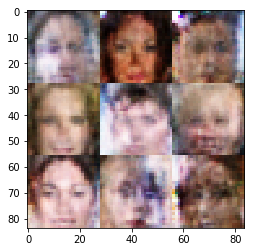

Epoch 1/1... Discriminator Loss: 1.4459... Generator Loss: 0.7542
Epoch 1/1... Discriminator Loss: 1.3969... Generator Loss: 0.7164
Epoch 1/1... Discriminator Loss: 1.3951... Generator Loss: 0.8149
Epoch 1/1... Discriminator Loss: 1.3933... Generator Loss: 0.6889
Epoch 1/1... Discriminator Loss: 1.4375... Generator Loss: 0.7111
Epoch 1/1... Discriminator Loss: 1.4078... Generator Loss: 0.7717
Epoch 1/1... Discriminator Loss: 1.4358... Generator Loss: 0.7096
Epoch 1/1... Discriminator Loss: 1.4236... Generator Loss: 0.7273
Epoch 1/1... Discriminator Loss: 1.4604... Generator Loss: 0.7578
Epoch 1/1... Discriminator Loss: 1.4226... Generator Loss: 0.7180


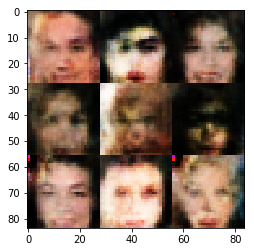

Epoch 1/1... Discriminator Loss: 1.4264... Generator Loss: 0.8215
Epoch 1/1... Discriminator Loss: 1.3970... Generator Loss: 0.8322
Epoch 1/1... Discriminator Loss: 1.4327... Generator Loss: 0.7221
Epoch 1/1... Discriminator Loss: 1.4301... Generator Loss: 0.7466
Epoch 1/1... Discriminator Loss: 1.3998... Generator Loss: 0.7230
Epoch 1/1... Discriminator Loss: 1.4451... Generator Loss: 0.7731
Epoch 1/1... Discriminator Loss: 1.4137... Generator Loss: 0.7829
Epoch 1/1... Discriminator Loss: 1.4055... Generator Loss: 0.7376
Epoch 1/1... Discriminator Loss: 1.4160... Generator Loss: 0.8468
Epoch 1/1... Discriminator Loss: 1.4119... Generator Loss: 0.8303


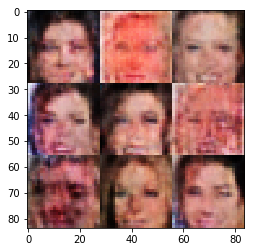

Epoch 1/1... Discriminator Loss: 1.4018... Generator Loss: 0.7859
Epoch 1/1... Discriminator Loss: 1.3954... Generator Loss: 0.7389
Epoch 1/1... Discriminator Loss: 1.4023... Generator Loss: 0.7721
Epoch 1/1... Discriminator Loss: 1.4263... Generator Loss: 0.7471
Epoch 1/1... Discriminator Loss: 1.4131... Generator Loss: 0.7586
Epoch 1/1... Discriminator Loss: 1.4123... Generator Loss: 0.8176
Epoch 1/1... Discriminator Loss: 1.4305... Generator Loss: 0.8024
Epoch 1/1... Discriminator Loss: 1.4036... Generator Loss: 0.7929
Epoch 1/1... Discriminator Loss: 1.4120... Generator Loss: 0.7436
Epoch 1/1... Discriminator Loss: 1.4449... Generator Loss: 0.7395


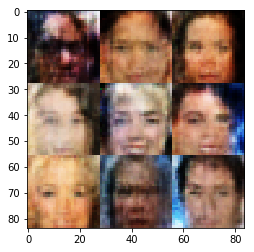

Epoch 1/1... Discriminator Loss: 1.4006... Generator Loss: 0.7985
Epoch 1/1... Discriminator Loss: 1.4153... Generator Loss: 0.7938
Epoch 1/1... Discriminator Loss: 1.4034... Generator Loss: 0.7851
Epoch 1/1... Discriminator Loss: 1.3965... Generator Loss: 0.8161
Epoch 1/1... Discriminator Loss: 1.4145... Generator Loss: 0.7568
Epoch 1/1... Discriminator Loss: 1.4100... Generator Loss: 0.8186
Epoch 1/1... Discriminator Loss: 1.4142... Generator Loss: 0.7215
Epoch 1/1... Discriminator Loss: 1.4224... Generator Loss: 0.7314
Epoch 1/1... Discriminator Loss: 1.4144... Generator Loss: 0.8423
Epoch 1/1... Discriminator Loss: 1.3772... Generator Loss: 0.8442


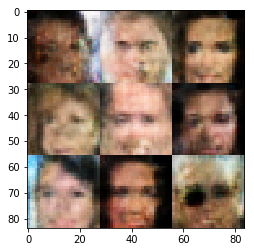

Epoch 1/1... Discriminator Loss: 1.3944... Generator Loss: 0.7809
Epoch 1/1... Discriminator Loss: 1.4591... Generator Loss: 0.6700
Epoch 1/1... Discriminator Loss: 1.4381... Generator Loss: 0.7194
Epoch 1/1... Discriminator Loss: 1.4077... Generator Loss: 0.7834
Epoch 1/1... Discriminator Loss: 1.4532... Generator Loss: 0.6627
Epoch 1/1... Discriminator Loss: 1.4027... Generator Loss: 0.8461
Epoch 1/1... Discriminator Loss: 1.4239... Generator Loss: 0.8746
Epoch 1/1... Discriminator Loss: 1.4233... Generator Loss: 0.7827
Epoch 1/1... Discriminator Loss: 1.3999... Generator Loss: 0.7747
Epoch 1/1... Discriminator Loss: 1.4136... Generator Loss: 0.7851


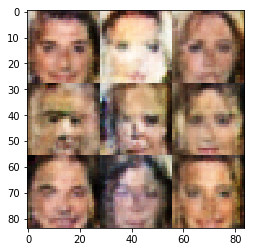

Epoch 1/1... Discriminator Loss: 1.3897... Generator Loss: 0.8071
Epoch 1/1... Discriminator Loss: 1.4309... Generator Loss: 0.7645
Epoch 1/1... Discriminator Loss: 1.3830... Generator Loss: 0.8044
Epoch 1/1... Discriminator Loss: 1.4320... Generator Loss: 0.7610
Epoch 1/1... Discriminator Loss: 1.4247... Generator Loss: 0.7454
Epoch 1/1... Discriminator Loss: 1.4268... Generator Loss: 0.7640
Epoch 1/1... Discriminator Loss: 1.3832... Generator Loss: 0.7875
Epoch 1/1... Discriminator Loss: 1.4017... Generator Loss: 0.8056
Epoch 1/1... Discriminator Loss: 1.3818... Generator Loss: 0.8088
Epoch 1/1... Discriminator Loss: 1.3724... Generator Loss: 0.7855


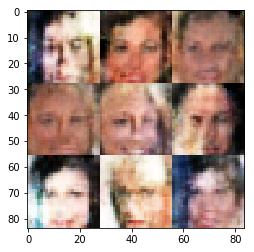

Epoch 1/1... Discriminator Loss: 1.4065... Generator Loss: 0.7925
Epoch 1/1... Discriminator Loss: 1.4331... Generator Loss: 0.7758
Epoch 1/1... Discriminator Loss: 1.4082... Generator Loss: 0.7980
Epoch 1/1... Discriminator Loss: 1.4188... Generator Loss: 0.7782
Epoch 1/1... Discriminator Loss: 1.4455... Generator Loss: 0.6880
Epoch 1/1... Discriminator Loss: 1.4264... Generator Loss: 0.7035
Epoch 1/1... Discriminator Loss: 1.4306... Generator Loss: 0.7745


KeyboardInterrupt: 

In [14]:
batch_size = 50
z_dim = 100
learning_rate = 0.0002
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.

In [ ]:
print ("hello")